# Testing of the patt_mcmc module's different samplers

In [1]:
from patt_mcmc import *
import mcmc_utils as mcu
import plotting_functions as pfs
import numpy as np
import numpy.linalg as alg
import numpy.random as rnd
import matplotlib.pyplot as plt

In [2]:
n_chains = 10
n_burn = int(1e4)
n_its = int(1e5)
n_samples = n_chains * n_its

### GPSS

In [3]:
d = 100
x_0s = rnd.normal(scale=d, size=(n_chains,d))
w_burn = d**2
w_att = 10*d

In [4]:
c = np.arange(d)

# multivariate Cauchy distribution with substantially non-zero center but trivial shape parameter
def log_density(x):
    return -(d+1)/2 * np.log(1 + alg.norm(x - c)**2)

In [5]:
ret_dic = patt_gpss(
    log_density,
    n_chains,
    n_burn,
    n_its,
    x_0s,
    cen_mode="medi",
    w_burn=w_burn,
    w_att=w_att,
)

Checking validity of given arguments...
Preparing for parallel sampling...
Preparing for init burn-in period...
Starting init burn-in sampling...
Preparing for ATT sampling...
Starting ATT sampling...


  0%|          | 0/100001 [00:00<?, ?it/s]

Assembling output...


In [6]:
burn_in = ret_dic['burn-in']
samples = ret_dic['samples']
medians = ret_dic['medians']
schedule = ret_dic['schedule']
tde_cnts = ret_dic['tde_cnts']
runtimes = ret_dic['runtimes']

In [7]:
print("TDE/it: {:.2f} (standard dev: {:.2f}), samples/s: {:.0f}".format(\
np.mean(tde_cnts[1:]), np.std(tde_cnts[1:]), n_samples / np.mean(np.sum(runtimes, axis=0))))

TDE/it: 7.34 (standard dev: 7.86), samples/s: 37523


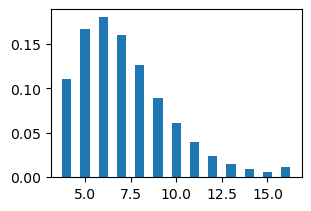

In [8]:
maxcnt = int(np.quantile(tde_cnts, 0.99))
filtered_tde_cnts = np.array([np.min([cnt, maxcnt]) for cnt in tde_cnts[1:].reshape(-1)])
pfs.plot_tde_distr(filtered_tde_cnts)

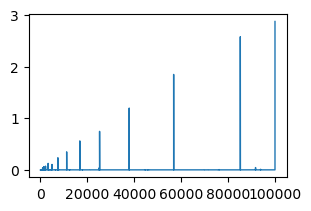

In [9]:
pfs.trace_plot(runtimes[:,0], lw=1)

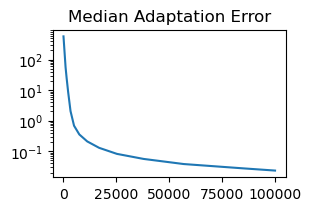

In [10]:
pfs.plot_ada_progress_testing(schedule, medians, c, "Median")

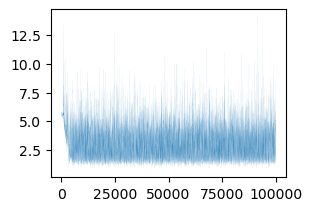

In [11]:
log_dist_from_c = mcu.get_log_radii(samples[:,0] - c)
pfs.trace_plot(log_dist_from_c)

### HRUSS

In [12]:
d = 37
x_0s = rnd.normal(scale=1, size=(n_chains,d))
w_burn = d
w_att = d

In [13]:
std = np.arange(1,d+1)

# mean zero Gaussian with highly inconsistent coordinate variances
def log_density(x):
    return -alg.norm(x / std)**2 / 2

In [14]:
ret_dic = patt_hruss(
    log_density,
    n_chains,
    n_burn,
    n_its,
    x_0s,
    cov_mode="var",
    w_burn=w_burn,
    w_att=w_att
)

Checking validity of given arguments...
Preparing for parallel sampling...
Preparing for init burn-in period...
Starting init burn-in sampling...
Preparing for ATT sampling...
Starting ATT sampling...


  0%|          | 0/100001 [00:00<?, ?it/s]

Assembling output...


In [15]:
burn_in = ret_dic['burn-in']
samples = ret_dic['samples']
means = ret_dic['means']
std_devs = ret_dic['std_devs']
schedule = ret_dic['schedule']
tde_cnts = ret_dic['tde_cnts']
runtimes = ret_dic['runtimes']

In [16]:
print("TDE/it: {:.2f} (standard dev: {:.2f}), samples/s: {:.0f}".format(\
np.mean(tde_cnts[1:]), np.std(tde_cnts[1:]), n_samples / np.mean(np.sum(runtimes, axis=0))))

TDE/it: 6.78 (standard dev: 2.54), samples/s: 63270


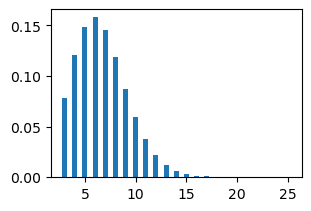

In [17]:
pfs.plot_tde_distr(tde_cnts[1:])

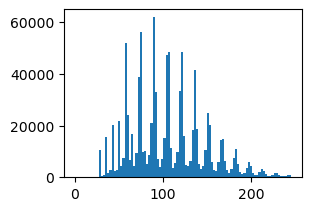

In [18]:
pfs.plot_runtime_hist(runtimes, cutoff_quant=0.99)

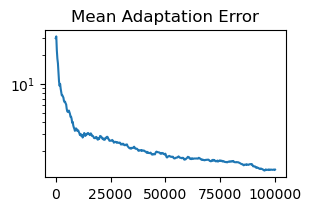

In [19]:
pfs.plot_ada_progress_testing(schedule, means, np.zeros(d), "Mean")

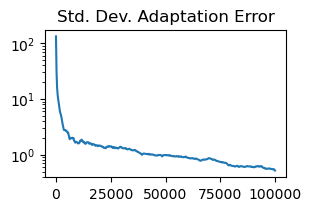

In [20]:
pfs.plot_ada_progress_testing(schedule, std_devs, std, "Std. Dev.")

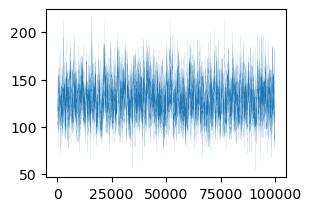

In [21]:
radii = mcu.get_radii(samples[:,0])
pfs.trace_plot(radii, lw=0.05)

### RSUSS

In [22]:
d = 29
x_0s = rnd.normal(scale=1, size=(n_chains,d))
w_burn = 1
w_att = 1

In [23]:
corr = 0.95
cov = np.full((d,d), corr) + (1 - corr) * np.identity(d)
inv_cov = alg.inv(cov)

# mean zero Gaussian with strongly correlated variables
def log_density(x):
    return -np.inner(x, inv_cov @ x) / 2

In [24]:
ret_dic = patt_rsuss(
    log_density,
    n_chains,
    n_burn,
    n_its,
    x_0s,
    cov_mode="cov",
    w_burn=w_burn,
    w_att=w_att,
)

Checking validity of given arguments...
Preparing for parallel sampling...
Preparing for init burn-in period...
Starting init burn-in sampling...
Preparing for ATT sampling...
Starting ATT sampling...


  0%|          | 0/100001 [00:00<?, ?it/s]

Assembling output...


In [25]:
burn_in = ret_dic['burn-in']
samples = ret_dic['samples']
means = ret_dic['means']
covs = ret_dic['covs']
schedule = ret_dic['schedule']
tde_cnts = ret_dic['tde_cnts']
runtimes = ret_dic['runtimes']

In [26]:
print("TDE/it: {:.2f} (standard dev: {:.2f}), samples/s: {:.0f}".format(\
np.mean(tde_cnts[1:]), np.std(tde_cnts[1:]), n_samples / np.mean(np.sum(runtimes, axis=0))))

TDE/it: 6.52 (standard dev: 1.46), samples/s: 67145


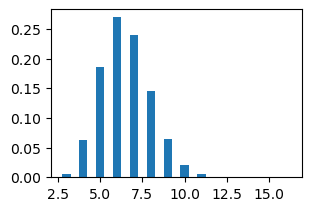

In [27]:
pfs.plot_tde_distr(tde_cnts[1:])

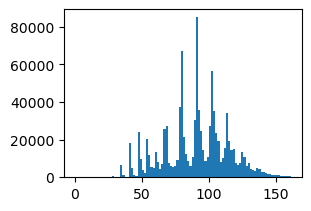

In [28]:
pfs.plot_runtime_hist(runtimes, cutoff_quant=0.99)

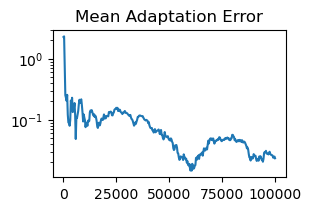

In [29]:
pfs.plot_ada_progress_testing(schedule, means, np.zeros(d), "Mean")

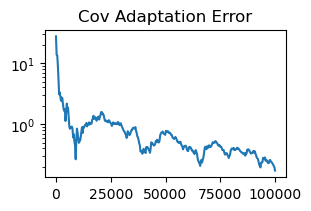

In [30]:
pfs.plot_ada_progress_testing(schedule, covs.reshape(-1, d*d), cov.reshape(-1, d*d), "Cov")

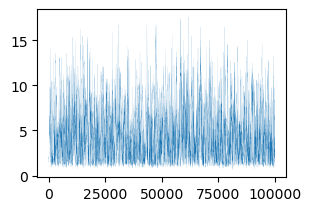

In [31]:
radii = mcu.get_radii(samples[:,0])
pfs.trace_plot(radii, lw=0.05)

### ESS

In [32]:
d = 23
x_0s = rnd.normal(scale=1, size=(n_chains,d))

In [33]:
c = np.full(d, np.sqrt(d))

# generalized Gaussian with somewhat non-zero mean but trivial covariance
def log_density(x):
    return -alg.norm(x - c)**3

In [34]:
ret_dic = patt_ess(
    log_density,
    n_chains,
    n_burn,
    n_its,
    x_0s,
    cen_mode="mean",
)

Checking validity of given arguments...
Preparing for parallel sampling...
Preparing for init burn-in period...
Starting init burn-in sampling...
Preparing for ATT sampling...
Starting ATT sampling...


  0%|          | 0/100001 [00:00<?, ?it/s]

Assembling output...


In [35]:
burn_in = ret_dic['burn-in']
tde_cnts_burn = ret_dic['tde_cnts_burn']
samples = ret_dic['samples']
means = ret_dic['means']
schedule = ret_dic['schedule']
tde_cnts = ret_dic['tde_cnts']
runtimes = ret_dic['runtimes']

In [36]:
print("TDE/it: {:.2f} (standard dev: {:.2f}), samples/s: {:.0f}".format(\
np.mean(tde_cnts[1:]), np.std(tde_cnts[1:]), n_samples / np.mean(np.sum(runtimes, axis=0))))

TDE/it: 5.45 (standard dev: 3.08), samples/s: 35126


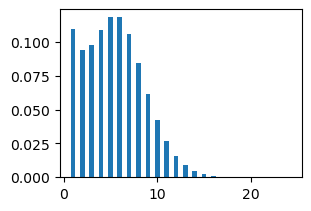

In [37]:
pfs.plot_tde_distr(tde_cnts[1:])

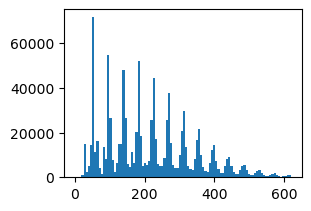

In [38]:
pfs.plot_runtime_hist(runtimes, cutoff_quant=0.99)

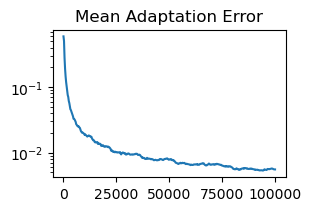

In [39]:
pfs.plot_ada_progress_testing(schedule, means, c, "Mean")

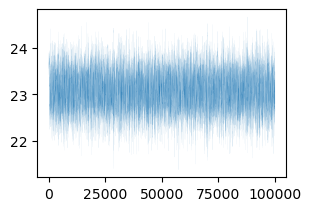

In [40]:
radii = mcu.get_radii(samples[:,0])
pfs.trace_plot(radii)